In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext
import torchtext.transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader
from torchlake.common.schemas.nlp import NlpContext
from torchlake.common.utils.platform import get_num_workers
from torchlake.common.utils.text import (build_vocab, get_unigram_counts,
                                         is_corpus_title, is_longer_text)
from torchlake.language_model.constants.enum import LossType, ModelType
from torchlake.language_model.controller.trainer_word2vec import (
    CbowTrainer, SkipGramTrainer)
from torchlake.language_model.models import Word2Vec
from torchlake.language_model.models.word2vec.loss import (HierarchicalSoftmax,
                                                           NegativeSampling)
from torchlake.language_model.utils.stats import subsampling_probability
from torchtext.data.utils import get_tokenizer, ngrams_iterator
from torchtext.datasets import WikiText2, WikiText103
from tqdm import tqdm

To utilize this notebook, you have to install `portalocker` first

In [2]:
torch.__version__

'2.1.0+cu118'

In [3]:
torchtext.__version__

'0.16.0+cpu'

# setting


In [4]:
DATASET_NAME = "wikiText2"

In [5]:
artifact_path = Path('../../artifacts/word2vec')
artifact_dataset_path = artifact_path / DATASET_NAME
data_path = Path('../../data') / DATASET_NAME

In [6]:
CONTEXT = NlpContext()

In [7]:
BATCH_SIZE = 32
CONTEXT_SIZE = 5

In [8]:
DEVICE = torch.device(CONTEXT.device)

In [9]:
tokenizer = get_tokenizer('basic_english')

In [10]:
def datapipe_factory(datapipe, context_size: int = 1, transform = None):
    datapipe = (
        datapipe
        .map(lambda text: text.strip())
        .map(lambda text: text.lower())
        .filter(lambda text: is_longer_text(text, context_size))
        .filter(lambda text: not is_corpus_title(text))
        .map(tokenizer)
        # .map(lambda text: drop_keywords(text, stopwords.words('english')))
        # .batch(batch_size)
        # .map(lambda text: F.to_tensor(text, padding_value=padding_idx))
    )

    if transform:
      datapipe = datapipe.map(transform)

    return datapipe

In [11]:
import random


def get_context(batch: list[torch.Tensor], maximum_context_size: int = 5, enable_random_context: bool = True)-> tuple[torch.Tensor, torch.Tensor]:
    """
    Args:
        batch: shape(batch_size, max_seq_len)

    Return:
        gram, context: shape(batch_size, 1 or context_size - 1, max_seq_len - context_size + 1)
    """
    # context is an odd that falls between 3 ~ maximum_context_size
    
    if maximum_context_size < 3:
        raise ValueError("contextss size is too small.")
    elif maximum_context_size % 2 == 0:
        raise ValueError("context size should be odd.")
    
    context_size = random.choice(list(range(3, maximum_context_size+1, 2))) if enable_random_context else maximum_context_size 

    half_size = context_size // 2
    context_indice = list(range(context_size))
    context_indice.pop(half_size)

    batch = torch.stack(batch)
    batch = batch.unfold(1, context_size, 1)
    gram = batch[:, :, half_size]
    context = batch[:, :, context_indice]

    return (
        gram.long().unsqueeze(1),
        context.long().transpose(-1, -2),
    )

In [12]:
train_datapipe, val_datapipe, test_datapipe = WikiText2(data_path.as_posix())

In [13]:
cloned_train_datapipe = datapipe_factory(train_datapipe, CONTEXT_SIZE)
vocab = build_vocab(cloned_train_datapipe)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [14]:
vocab_size = len(vocab)

In [15]:
# artifact_dataset_path.joinpath("vocab.json").write_text(
#     json.dumps(list(vocab.get_stoi().keys()))
# )

In [16]:
vocab.lookup_tokens(range(20))

['<unk>',
 '<bos>',
 '<eos>',
 '<pad>',
 'the',
 ',',
 '.',
 'of',
 'and',
 'in',
 'to',
 'a',
 'was',
 "'",
 '@-@',
 'on',
 'as',
 's',
 'that',
 'for']

In [17]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [18]:
train_datapipe = datapipe_factory(
    train_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

val_datapipe = datapipe_factory(
    val_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [19]:
NUM_WORKERS = get_num_workers()

In [20]:
train_dataloader = DataLoader(
    train_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=lambda data: get_context(data, CONTEXT_SIZE),
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

val_dataloader = DataLoader(
    val_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=lambda data: get_context(data, CONTEXT_SIZE),
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=lambda data: get_context(data, CONTEXT_SIZE),
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

In [21]:
# check context size
# for data in train_datapipe:
#     if len(data) < 5:
#         print(data)
#         break

In [22]:
# sample
# for data in train_datapipe:
#     if len(data) > 5:
#         print(data)
#         print(vocab.lookup_tokens(data))
#         break

In [23]:
# count = 0
# for data in train_datapipe:
#   count += len(data)
# count

In [24]:
# number of words in training corpurs
# wikitext2 count 1,993,228
# wikitext103 count 101,227,641

In [25]:
for gram, context in train_dataloader:
    print(gram.shape, context.shape)
    break

torch.Size([32, 1, 252]) torch.Size([32, 4, 252])


# subsampling


In [26]:
# load word frequency
# word_counts = json.loads(artifact_dataset_path.joinpath("word-count.json").read_text())
# word_counts = torch.LongTensor(word_counts)

In [27]:
word_counts = get_unigram_counts(
    map(lambda x: x.tolist(), train_datapipe),
    vocab_size,
    freq=False,
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [28]:
word_freqs = get_unigram_counts(
    map(lambda x: x.tolist(), train_datapipe),
    vocab_size,
    freq=True,
)

In [29]:
word_freqs.shape

torch.Size([20351])

In [30]:
sum(word_freqs)

tensor(1.0001)

In [31]:
sum(word_counts)

tensor(4468736)

In [32]:
subsampling_threshold = 1e-5

In [33]:
word_probs = (
    subsampling_probability(word_freqs, subsampling_threshold)
    .maximum(torch.zeros((1))) # avoid negative number
    .to(DEVICE)
)

In [34]:
# the formula itself does not need normalization
sum(word_probs)

tensor(1505.4606, device='cuda:0')

Text(0, 0.5, 'drop probability')

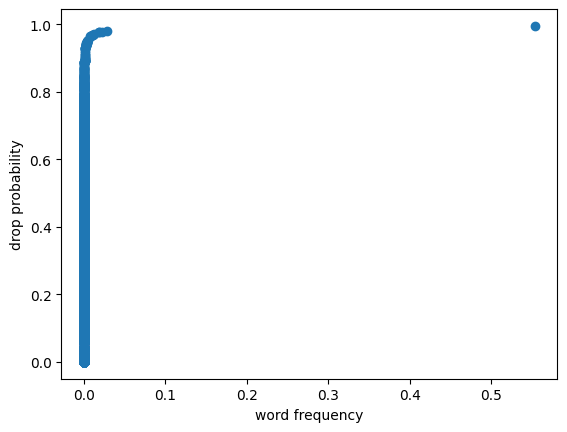

In [35]:
plt.scatter(word_freqs, word_probs.cpu())
plt.xlabel("word frequency")
plt.ylabel("drop probability")

In [36]:
# save word frequency
# artifact_wikitext2_path.joinpath("word-count.json").write_text(json.dumps(word_counts.tolist()))

# training


In [37]:
EMBED_DIM = 300

In [38]:
EPOCHES = 20

## cross entropy


### SkipGram


batch size 32, context size 5

each epoch needs 2min, 11.6GB with 4 workers on linux

each epoch needs 73min, 11.6GB with none workers on windows

In [39]:
model = Word2Vec(
    vocab_size,
    EMBED_DIM,
    ModelType.SKIP_GRAM,
    context=CONTEXT,
).to(DEVICE)

In [40]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Word2Vec                                 --
├─Linear: 1-1                            6,125,651
├─SkipGram: 1-2                          --
│    └─Embedding: 2-1                    6,105,300
Total params: 12,230,951
Trainable params: 12,230,951
Non-trainable params: 0

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [42]:
trainer = SkipGramTrainer(EPOCHES, DEVICE)
training_loss = trainer.run(train_dataloader, model, optimizer, criterion, word_probs)

547it [02:20,  3.90it/s]


epoch 1 : 0.3087980635225172


547it [02:20,  3.91it/s]


epoch 2 : 0.3008768631164138


547it [02:02,  4.47it/s]


epoch 3 : 0.2930864764396255


547it [01:51,  4.91it/s]


epoch 4 : 0.28571212783414873


547it [01:51,  4.91it/s]


epoch 5 : 0.2787685870140873


547it [01:51,  4.90it/s]


epoch 6 : 0.27227624281079915


547it [01:51,  4.90it/s]


epoch 7 : 0.2660893277221596


547it [01:51,  4.89it/s]


epoch 8 : 0.26012423175611593


547it [01:51,  4.89it/s]


epoch 9 : 0.2543126828183175


547it [01:51,  4.89it/s]


epoch 10 : 0.24859831043058966


547it [01:51,  4.89it/s]


epoch 11 : 0.2429566849108468


547it [02:03,  4.44it/s]


epoch 12 : 0.23735726671848245


547it [02:18,  3.95it/s]


epoch 13 : 0.2317677917937201


547it [02:11,  4.15it/s]


epoch 14 : 0.22624234862004147


547it [02:11,  4.15it/s]


epoch 15 : 0.22074919936309487


547it [02:13,  4.08it/s]


epoch 16 : 0.2153011620809571


547it [02:12,  4.13it/s]


epoch 17 : 0.20986061034456072


547it [02:00,  4.54it/s]


epoch 18 : 0.20452876289321348


547it [01:52,  4.87it/s]


epoch 19 : 0.19922385570327697


547it [01:58,  4.61it/s]

epoch 20 : 0.1940036424521893


[0.3087980635225172,
 0.3008768631164138,
 0.2930864764396255,
 0.28571212783414873,
 0.2787685870140873,
 0.27227624281079915,
 0.2660893277221596,
 0.26012423175611593,
 0.2543126828183175,
 0.24859831043058966,
 0.2429566849108468,
 0.23735726671848245,
 0.2317677917937201,
 0.22624234862004147,
 0.22074919936309487,
 0.2153011620809571,
 0.20986061034456072,
 0.20452876289321348,
 0.19922385570327697,
 0.1940036424521893]

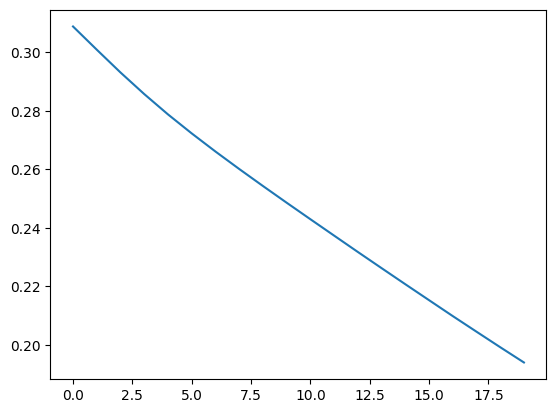

In [44]:
plt.plot(training_loss)

In [45]:
model_path = artifact_path / "sg.2.pth"

In [46]:
torch.save(model, model_path.as_posix())

In [96]:
model = torch.load(model_path.as_posix())

### CBOW


batch size 32, context size 5

each epoch needs 42s, 3.6GB with 4 workers on linux

each epoch needs 42s, 3.6GB with none workers on windows

In [39]:
model = Word2Vec(
    vocab_size,
    EMBED_DIM,
    CONTEXT_SIZE,
    ModelType.CBOW,
    context=CONTEXT,
).to(DEVICE)

In [38]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Word2Vec                                 --
├─Linear: 1-1                            6,125,651
├─Cbow: 1-2                              --
│    └─Embedding: 2-1                    6,105,300
Total params: 12,230,951
Trainable params: 12,230,951
Non-trainable params: 0

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)

In [41]:
trainer = CbowTrainer(EPOCHES, DEVICE)
training_loss = trainer.run(train_dataloader, model, optimizer, criterion, word_probs)

547it [00:46, 11.89it/s]


epoch 1 : 0.32005459873311354


547it [00:42, 12.78it/s]


epoch 2 : 0.31551956840877027


547it [00:42, 12.82it/s]


epoch 3 : 0.31102606066862015


547it [00:41, 13.06it/s]


epoch 4 : 0.3068001818809894


547it [00:41, 13.19it/s]


epoch 5 : 0.3031790271797495


547it [00:41, 13.12it/s]


epoch 6 : 0.30030418529519237


547it [00:41, 13.09it/s]


epoch 7 : 0.29790209352587693


547it [00:41, 13.11it/s]


epoch 8 : 0.2958969196849302


547it [00:42, 12.84it/s]


epoch 9 : 0.29419840086937826


547it [00:41, 13.33it/s]


epoch 10 : 0.29271949850890094


547it [00:40, 13.45it/s]


epoch 11 : 0.2913915446654686


547it [00:40, 13.61it/s]


epoch 12 : 0.2901640788444568


547it [00:41, 13.32it/s]


epoch 13 : 0.28900249833693537


547it [00:40, 13.39it/s]


epoch 14 : 0.2878982385946566


547it [00:40, 13.66it/s]


epoch 15 : 0.28687833330152673


547it [00:40, 13.65it/s]


epoch 16 : 0.28587390221552933


547it [00:39, 13.69it/s]


epoch 17 : 0.2849168373181337


547it [00:39, 13.69it/s]


epoch 18 : 0.28399199312919876


547it [00:33, 16.24it/s]


epoch 19 : 0.28306203162746624


547it [00:33, 16.26it/s]

epoch 20 : 0.2821944672836283


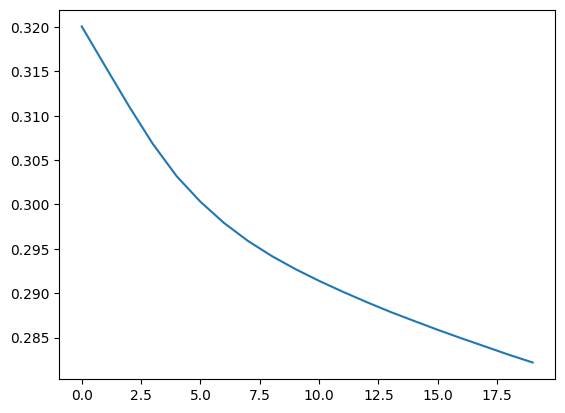

In [42]:
plt.plot(training_loss)

In [43]:
model_path = artifact_path / "cb.2.pth"

In [44]:
torch.save(model, model_path.as_posix())

In [328]:
model = torch.load(model_path.as_posix())

## NS


batch size 32, context size 5

each epoch needs 100s, 10GB with 4 workers on linux

batch size 32, context size 5

each epoch needs 73m, 1.7GB with none workers on windows

### SkipGram


In [39]:
model = Word2Vec(
    vocab_size,
    EMBED_DIM,
    ModelType.SKIP_GRAM,
    loss_type=LossType.NS,
    context=CONTEXT,
).to(DEVICE)

In [40]:
criterion = NegativeSampling(word_freqs, EMBED_DIM, vocab_size, context=CONTEXT).to(DEVICE)
optimizer = optim.SGD([*model.parameters(), *criterion.parameters()], lr=1e-3)

In [41]:
trainer = SkipGramTrainer(EPOCHES, DEVICE)
training_loss = trainer.run(train_dataloader, model, optimizer, criterion, word_probs)

546it [01:12,  7.49it/s]


epoch 1 : 1708.149009250043


546it [01:08,  7.99it/s]


epoch 2 : 1403.1050937558182


546it [01:06,  8.18it/s]


epoch 3 : 1214.8448687167916


546it [01:05,  8.37it/s]


epoch 4 : 1095.2124243298329


546it [01:06,  8.23it/s]


epoch 5 : 1088.4283948525936


546it [01:11,  7.63it/s]


epoch 6 : 1024.7347238122816


546it [01:05,  8.27it/s]


epoch 7 : 902.5408464496448


546it [01:10,  7.74it/s]


epoch 8 : 883.0412290522421


546it [01:11,  7.60it/s]


epoch 9 : 905.4069820302653


546it [01:10,  7.77it/s]


epoch 10 : 830.4087335882003


546it [01:10,  7.70it/s]


epoch 11 : 826.6726763451678


546it [01:12,  7.56it/s]


epoch 12 : 823.7295012504654


546it [01:10,  7.79it/s]


epoch 13 : 757.6474490213787


546it [01:15,  7.28it/s]


epoch 14 : 785.6849327192298


546it [01:18,  6.99it/s]


epoch 15 : 769.69487115596


546it [01:14,  7.33it/s]


epoch 16 : 752.4447977011844


546it [01:13,  7.43it/s]


epoch 17 : 740.6779258161592


546it [01:14,  7.36it/s]


epoch 18 : 738.3015512104541


546it [01:09,  7.84it/s]


epoch 19 : 684.36737524884


546it [01:12,  7.58it/s]

epoch 20 : 717.1233577570929


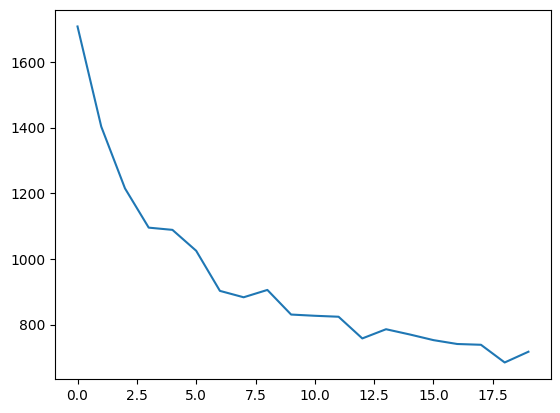

In [42]:
plt.plot(training_loss)

In [43]:
model_path = artifact_path / "sg-ns.2.random-context.pth"

In [44]:
torch.save(model, model_path.as_posix())

In [368]:
model = torch.load(model_path.as_posix())

### CBOW


batch size 32, context size 5

each epoch needs 30s, 5.5GB with 4 workers on linux

each epoch needs 12min, 1.5GB with none workers on windows

In [39]:
model = Word2Vec(
    vocab_size,
    EMBED_DIM,
    CONTEXT_SIZE,
    ModelType.CBOW,
    LossType.NS,
    context=CONTEXT,
).to(DEVICE)

In [40]:
criterion = NegativeSampling(
    word_freqs,
    EMBED_DIM,
    vocab_size,
    context=CONTEXT,
).to(DEVICE)
optimizer = optim.SGD([*model.parameters(), *criterion.parameters()], lr=1e-4)

In [42]:
trainer = CbowTrainer(EPOCHES, DEVICE)
training_loss = trainer.run(train_dataloader, model, optimizer, criterion, word_probs)

547it [00:31, 17.59it/s]


epoch 1 : 421.13764485080344


547it [00:28, 18.94it/s]


epoch 2 : 342.3750703498707


547it [00:28, 19.26it/s]


epoch 3 : 314.81653808258085


547it [00:29, 18.79it/s]


epoch 4 : 299.2037936174793


547it [00:28, 19.32it/s]


epoch 5 : 289.14561033030367


547it [00:28, 19.33it/s]


epoch 6 : 281.80886286972424


547it [00:28, 19.35it/s]


epoch 7 : 275.9343293327241


547it [00:28, 19.18it/s]


epoch 8 : 271.7440600932792


547it [00:30, 18.10it/s]


epoch 9 : 266.34392121731963


547it [00:29, 18.60it/s]


epoch 10 : 262.71269658243403


547it [00:29, 18.35it/s]


epoch 11 : 259.51177265226676


547it [00:26, 20.58it/s]


epoch 12 : 257.38871531569555


547it [00:26, 20.29it/s]


epoch 13 : 254.5563600926526


547it [00:26, 20.30it/s]


epoch 14 : 252.29866955107664


547it [00:27, 20.02it/s]


epoch 15 : 248.99950808237497


547it [00:26, 20.33it/s]


epoch 16 : 248.3588456836564


547it [00:26, 20.58it/s]


epoch 17 : 245.92208151812952


547it [00:26, 20.48it/s]


epoch 18 : 245.35420331946216


547it [00:26, 20.42it/s]


epoch 19 : 242.14197113009138


547it [00:26, 20.51it/s]

epoch 20 : 240.88479421250216


[421.13764485080344,
 342.3750703498707,
 314.81653808258085,
 299.2037936174793,
 289.14561033030367,
 281.80886286972424,
 275.9343293327241,
 271.7440600932792,
 266.34392121731963,
 262.71269658243403,
 259.51177265226676,
 257.38871531569555,
 254.5563600926526,
 252.29866955107664,
 248.99950808237497,
 248.3588456836564,
 245.92208151812952,
 245.35420331946216,
 242.14197113009138,
 240.88479421250216]

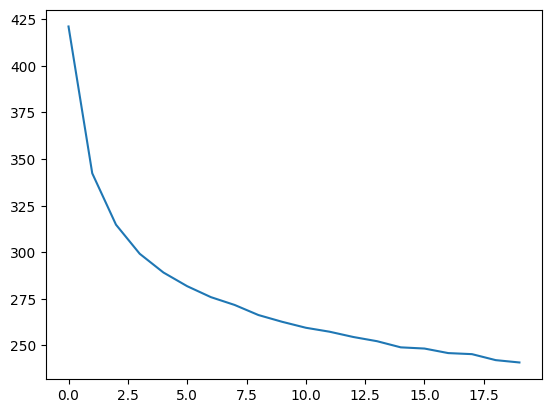

In [44]:
plt.plot(training_loss)

In [45]:
model_path = artifact_path / "cb-ns.2.pth"

In [46]:
torch.save(model, model_path.as_posix())

In [379]:
model = torch.load(model_path.as_posix())

## HS


### SkipGram


batch size 32, context size 5

each epoch needs 50s, 7.5GB with 4 workers on linux

each epoch needs min, GB with none workers on windows

In [39]:
model = Word2Vec(
    vocab_size,
    EMBED_DIM,
    ModelType.SKIP_GRAM,
    LossType.HS,
    context=CONTEXT,
).to(DEVICE)

In [40]:
criterion = HierarchicalSoftmax(
    word_counts,
    EMBED_DIM,
    vocab_size,
    context=CONTEXT,
).to(DEVICE)
optimizer = optim.SGD([*model.parameters(), *criterion.parameters()], lr=1e-3)

In [41]:
trainer = SkipGramTrainer(EPOCHES, DEVICE)
training_loss = trainer.run(train_dataloader, model, optimizer, criterion, word_probs)

546it [00:39, 13.89it/s]


epoch 1 : 0.1173579934455188


546it [00:39, 13.91it/s]


epoch 2 : 0.09393413118355652


546it [00:41, 13.31it/s]


epoch 3 : 0.08620688226330073


546it [00:44, 12.15it/s]


epoch 4 : 0.08339510082269785


546it [00:48, 11.24it/s]


epoch 5 : 0.08149199057319206


546it [00:46, 11.78it/s]


epoch 6 : 0.07983706359547502


546it [00:45, 11.99it/s]


epoch 7 : 0.07842107030446108


546it [00:44, 12.19it/s]


epoch 8 : 0.07719061535285439


546it [00:46, 11.67it/s]


epoch 9 : 0.07609419253553194


546it [00:47, 11.44it/s]


epoch 10 : 0.07515856055465998


546it [00:44, 12.15it/s]


epoch 11 : 0.07436773553832095


546it [00:44, 12.14it/s]


epoch 12 : 0.0736223155142625


546it [00:46, 11.75it/s]


epoch 13 : 0.07287868210665137


546it [00:45, 12.01it/s]


epoch 14 : 0.07221920698826516


546it [00:45, 11.91it/s]


epoch 15 : 0.07156809504757662


546it [00:49, 11.12it/s]


epoch 16 : 0.0708941439837627


546it [00:48, 11.17it/s]


epoch 17 : 0.07036363330049104


546it [00:45, 11.88it/s]


epoch 18 : 0.0697729457869757


546it [00:45, 12.07it/s]


epoch 19 : 0.06923326075514122


546it [00:46, 11.72it/s]

epoch 20 : 0.06876227408510954


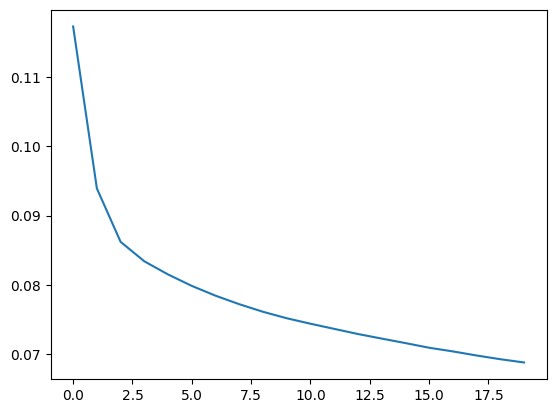

In [42]:
plt.plot(training_loss)

In [43]:
model_path = artifact_path / "sg-hs.2.random-context.pth"

In [44]:
torch.save(model, model_path.as_posix())

In [ ]:
model = torch.load(model_path.as_posix())

### CBOW


batch size 32, context size 5

each epoch needs 15s, 3.3GB with 4 workers on linux

each epoch needs min, GB with none workers on windows

In [55]:
model = Word2Vec(
    vocab_size,
    EMBED_DIM,
    CONTEXT_SIZE,
    ModelType.CBOW,
    LossType.HS,
    context=CONTEXT,
).to(DEVICE)

In [56]:
criterion = HierarchicalSoftmax(
    word_counts,
    EMBED_DIM,
    vocab_size,
    context=CONTEXT,
).to(DEVICE)
optimizer = optim.SGD([*model.parameters(), *criterion.parameters()], lr=1e-3)

In [57]:
trainer = CbowTrainer(EPOCHES, DEVICE)
training_loss = trainer.run(train_dataloader, model, optimizer, criterion, word_probs)

547it [00:17, 30.52it/s]


epoch 1 : 0.17942986124486252


547it [00:14, 37.03it/s]


epoch 2 : 0.1666779303692766


547it [00:14, 38.42it/s]


epoch 3 : 0.15994363399026157


547it [00:14, 37.94it/s]


epoch 4 : 0.15522356833972373


547it [00:14, 38.45it/s]


epoch 5 : 0.1516314132649564


547it [00:14, 38.52it/s]


epoch 6 : 0.1485341561567226


547it [00:14, 38.69it/s]


epoch 7 : 0.1460283011416576


547it [00:15, 35.47it/s]


epoch 8 : 0.14376579286525493


547it [00:18, 29.95it/s]


epoch 9 : 0.14183737579340458


547it [00:16, 33.68it/s]


epoch 10 : 0.14019999233109487


547it [00:15, 35.90it/s]


epoch 11 : 0.13858588192847537


547it [00:14, 36.78it/s]


epoch 12 : 0.13716941925771295


547it [00:14, 37.29it/s]


epoch 13 : 0.13584011077443794


547it [00:14, 36.97it/s]


epoch 14 : 0.1346365648136567


547it [00:14, 36.93it/s]


epoch 15 : 0.1333807571889281


547it [00:14, 37.86it/s]


epoch 16 : 0.1323354737431931


547it [00:14, 39.01it/s]


epoch 17 : 0.13139466482439138


547it [00:14, 38.78it/s]


epoch 18 : 0.13044138926087334


547it [00:14, 38.93it/s]


epoch 19 : 0.1294636450892299


547it [00:14, 38.48it/s]

epoch 20 : 0.12860948452427232


[0.17942986124486252,
 0.1666779303692766,
 0.15994363399026157,
 0.15522356833972373,
 0.1516314132649564,
 0.1485341561567226,
 0.1460283011416576,
 0.14376579286525493,
 0.14183737579340458,
 0.14019999233109487,
 0.13858588192847537,
 0.13716941925771295,
 0.13584011077443794,
 0.1346365648136567,
 0.1333807571889281,
 0.1323354737431931,
 0.13139466482439138,
 0.13044138926087334,
 0.1294636450892299,
 0.12860948452427232]

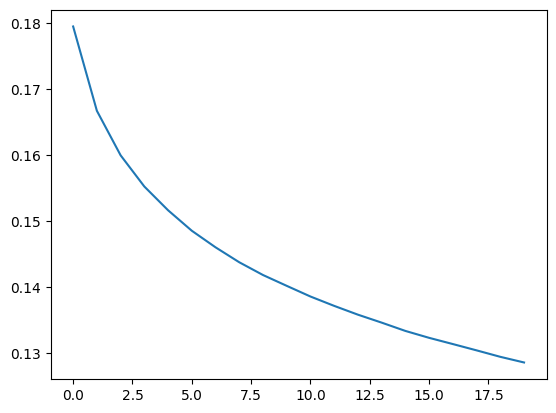

In [58]:
plt.plot(training_loss)

In [59]:
model_path = artifact_path / "cb-hs.2.pth"

In [60]:
torch.save(model, model_path.as_posix())

In [ ]:
model = torch.load(model_path.as_posix())

# Evaluation


## show embedding


In [45]:
from torchtext.vocab import Vocab

In [46]:
def sentence_to_vector(sentence: str, embedding: nn.Embedding, vocab: Vocab, device: torch.device) -> torch.Tensor:
    with torch.no_grad():
      tokens = tokenizer(sentence)
      indices = torch.LongTensor(vocab(tokens)).to(device)
      return embedding(indices)

In [47]:
sample_word_pairs = [
    ["paris", "france"],
    ["beijing", "china"],
    ["moscow", "russia"],
    ["tokyo", "japan"],
    ["athens", "greece"],
    ["rome", "italy"],
    ["berlin", "germany"],
    ["madrid", "spain"],
    ["lisbon", "portugal"],
]

In [48]:
vectors = []
for pair in sample_word_pairs:
    vectors.append(torch.cat([sentence_to_vector(item, model.embeddings, vocab, DEVICE) for item in pair]))

vectors = torch.cat(vectors)

In [49]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [50]:
projector = PCA(2)
projector.fit(model.embeddings.weight.clone().detach().cpu())

PCA(n_components=2)

In [ ]:
projector = TSNE(perplexity=2)
projector.fit(model.embeddings.weight.clone().detach().cpu())

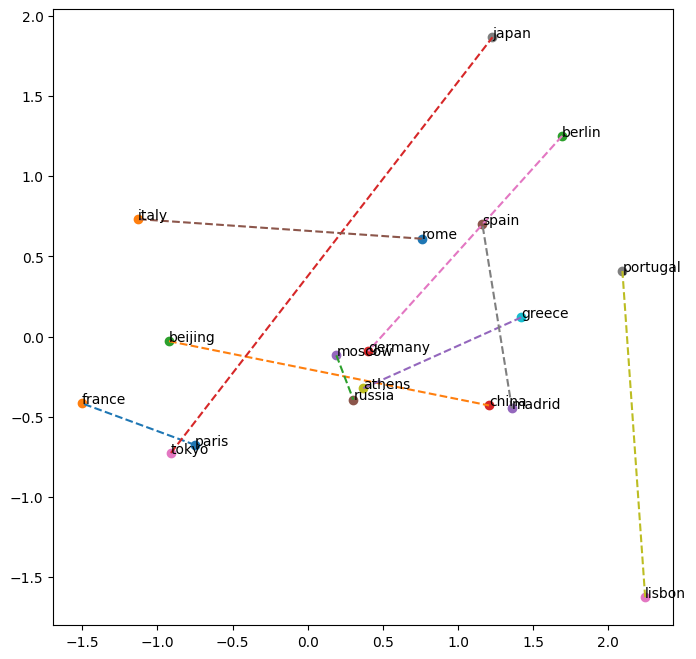

In [385]:
projected = projector.transform(vectors.detach().cpu())

plt.figure(figsize=(8,8))
for i in range(0, len(projected), 2):
    pair = sample_word_pairs[i // 2]

    plt.plot(projected[i:i+2, 0], projected[i:i+2, 1], '--')

    for j in range(2):
        x, y = projected[i+j, 0], projected[i+j, 1]
        plt.scatter(x, y)
        plt.text(x, y, pair[j])

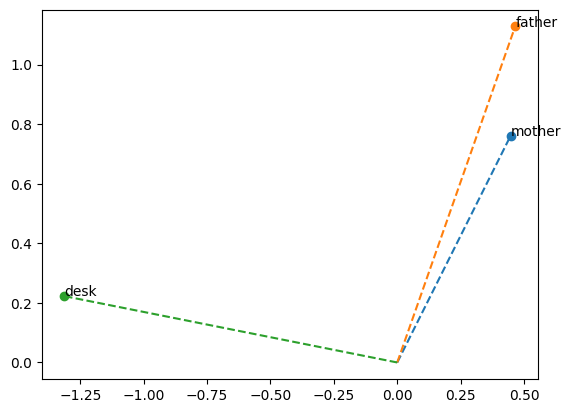

In [ ]:
demo = 'mother father desk'
projected = projector.transform(vectors.detach().cpu())
for j in range(3):
  x, y = projected[j, 0], projected[j, 1]
  plt.scatter(x, y)
  plt.text(x, y, tokenizer(demo)[j])
  plt.plot(torch.Tensor([0, x]), torch.Tensor([0, y]), '--')

## Simple QA / relationship inference

prove linear composability


In [387]:
question = sentence_to_vector('berlin') - sentence_to_vector('germany')

In [388]:
acc = 0

metric = nn.CosineSimilarity()
choices = [capital for capital, country in sample_word_pairs]
for capital, country in sample_word_pairs:
  print('question:', country)
  guess = metric(question + sentence_to_vector(country), sentence_to_vector(" ".join(choices)))
  # guess = metric(question, model.embeddings.weight)
  # print(guess)
  topk_guess_value, topk_guess_idx = guess.topk(3, largest=True)
  answer = [choices[g] for g in topk_guess_idx]
  print(topk_guess_value)
  # answer = vocab.lookup_tokens([guess[4:].abs().argmin()])
  print('answer:', answer)
  print('-------------------------------')

  acc += answer[0] == capital

print(f"{acc}/{len(sample_word_pairs)}")

question: france
tensor([0.5920, 0.0461, 0.0130], device='cuda:0')
answer: ['berlin', 'beijing', 'rome']
-------------------------------
question: china
tensor([0.5827, 0.0960, 0.0737], device='cuda:0')
answer: ['berlin', 'athens', 'beijing']
-------------------------------
question: russia
tensor([0.5642, 0.0994, 0.0861], device='cuda:0')
answer: ['berlin', 'beijing', 'paris']
-------------------------------
question: japan
tensor([0.5794, 0.0735, 0.0387], device='cuda:0')
answer: ['berlin', 'moscow', 'beijing']
-------------------------------
question: greece
tensor([0.5650, 0.1255, 0.0694], device='cuda:0')
answer: ['berlin', 'beijing', 'athens']
-------------------------------
question: italy
tensor([0.6387, 0.1244, 0.1070], device='cuda:0')
answer: ['berlin', 'beijing', 'rome']
-------------------------------
question: germany
tensor([1.0000, 0.0849, 0.0374], device='cuda:0')
answer: ['berlin', 'lisbon', 'madrid']
-------------------------------
question: spain
tensor([0.6523, 0.1

## phrase construction


In [ ]:
from collections import Counter

In [ ]:
import nltk
from nltk.corpus import stopwords

In [ ]:
# nltk.__version__

In [ ]:
nltk.download('stopwords')

In [ ]:
stopwords.words('english')[:10]

In [ ]:
# bigram count / unigram product => keep filtering

torch.Size([6, 128])

In [487]:
train_datapipe, val_datapipe, test_datapipe = WikiText2("./data")

In [488]:
ngrams_counter = Counter()
for data in datapipe_factory(train_datapipe):
    ngrams_counter.update(ngrams_iterator(data, 2))

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [489]:
for stopword in stopwords.words('english'):
    ngrams_counter.pop(stopword, "")

import string

for stopword in string.ascii_letters + string.punctuation:
    ngrams_counter.pop(stopword, "")

In [490]:
iter_limit = 1
frequent_word_threshold = sum(ngrams_counter) * 1e-4
count_threshold = 5e-5
count_threshold_factor = 0.8

In [491]:
phrases = set()
bigrams = [key for key in ngrams_counter.keys() if " " in key and key != ""]
for _ in range(iter_limit):
   for bigram in tqdm(bigrams):
      gram1, gram2 = bigram.split(" ")
      gram1_count, gram2_count = ngrams_counter[gram1], ngrams_counter[gram2]

      if gram1_count > frequent_word_threshold or gram2_count > frequent_word_threshold:
         continue

      if gram1_count == 0 or gram2_count == 0:
         continue

      lift = ngrams_counter[bigram] / (gram1_count * gram2_count)
      # print(bigram, lift)
      if lift > count_threshold:
         phrases.add(bigram)
      else:
         bigrams.remove(bigram)
      
      count_threshold *= count_threshold_factor

100%|█████████▉| 577048/577049 [00:00<00:00, 672551.02it/s]


In [ ]:
phrases

In [493]:
ngrams_counter['video game'] / (ngrams_counter['video'] * ngrams_counter['game'])

7.172148157986485e-05

In [494]:
'video game' in phrases

True

# Profiling

In [1]:
import torch.autograd.profiler as profiler

In [ ]:
for gram, context in train_dataloader:
    
    with profiler.profile(with_stack=True, profile_memory=True) as prof:
        gram = gram.to(CONTEXT.device)
        context = context.to(CONTEXT.device)
        
        output = model(gram, word_probs)
        loss = criterion(output, context)
        loss.backward()
        
    break

In [54]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=100))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             aten::topk        15.59%     293.022ms        15.59%     293.022ms     293.022ms           0 b           0 b           0 b           0 b             1  
                                 aten::_index_put_impl_        13.37%     251.247ms        25.81%     485.048ms     242.524ms           0 b          -8 b           0 b     -48.05 Mb             2  
         